In [1]:
# import sys,os
##### Change "0" to GPU device number you want to use if you have multiple GPU devices
# os.environ['CUDA_VISIBLE_DEVICES'] ="0" 

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [3]:
import tensorflow as tf
import numpy as np
import aux_functions as af
import models as Mo
from attack import Attack
import sys
import time

In [4]:
x_train,y_train,x_test,y_test = af.load_mnist_dataset()

Sample Images ...


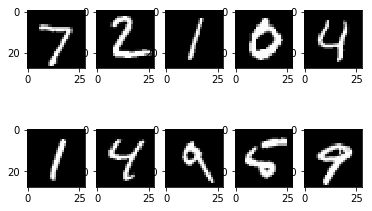

In [5]:
print 'Sample Images ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i,:,:,0])

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
x = tf.placeholder(tf.float32,[None,28,28,1])
y = tf.placeholder(tf.float32,[None,10])
target_model = Mo.SimpleCNN2(x,y,sess,var_scope='simpleCNN2',path = './target_model_cnn2')
target_model.test_model(x_test,y_test)
sub_model = Mo.SimpleCNN3(x,y,sess,var_scope='simpleCNN3_1')
sub_model2 = Mo.SimpleCNN3(x,y,sess,var_scope='SimpleCNN3_2')

INFO:tensorflow:Restoring parameters from ./target_model_cnn2
model accuracy is: 0.9937


In [7]:
##### Training with noisy data augmentation (SST)
sub_model.SST(x_test[:100],target_model,lr=0.001,nb_epochs=1400,start_range=0,end_range=100,step=5)
sub_model.SST(x_test[:100],target_model,lr=0.0001,nb_epochs=1400,start_range=0,end_range=100,step=5)
sub_model.SST(x_test[:100],target_model,lr=0.00005,nb_epochs=1400,start_range=0,end_range=100,step=5)

epoch: 1400/1400 iter: 0/1 loss: 2.2253 
epoch: 1400/1400 iter: 0/1 loss: 0.4076 
epoch: 1400/1400 iter: 0/1 loss: 0.3365 


In [8]:
##### Training without noisy data augmentation
sub_model2.SST(x_test[:100],target_model,lr=0.001,nb_epochs=1400,start_range=0,end_range=0,step=1)
sub_model2.SST(x_test[:100],target_model,lr=0.0001,nb_epochs=1400,start_range=0,end_range=0,step=1)
sub_model2.SST(x_test[:100],target_model,lr=0.00005,nb_epochs=1400,start_range=0,end_range=0,step=1)

epoch: 1400/1400 iter: 0/1 loss: 1.0599 
epoch: 1400/1400 iter: 0/1 loss: 0.0012 
epoch: 1400/1400 iter: 0/1 loss: 0.0003 


In [10]:
print 'Accuracy of substitute model with SST:'
sub_model.test_model(x_test,y_test)
print 'Accuracy of substitute model without SST:'
sub_model2.test_model(x_test,y_test)

Accuracy of substitute model with SST:
model accuracy is: 0.9712
Accuracy of substitute model without SST:
model accuracy is: 0.8635


Crafting adversarial examples against target model using  SST model ...
run: 5/5 iter: 500/500 success rate: 1.0000 
Total attack time: 100.724849939
Success Rate:  1.0
AVG L2 norm of crafted Adv. Examples: 1.5699530048199006
Sample Adv. Examples ...


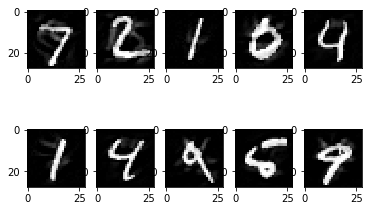

In [11]:
print 'Crafting adversarial examples against target model using  SST model ...'
atk1 = Attack(x,y,[sub_model],target_model,sess,100,lr=0.05)
st = time.time()
index = 0
legit_img = x_test[index:index+100]
legit_y = y_test[index:index+100]
other_params = {
    'total_run':5,
    'total_iters':500
}
adv_img1 = atk1.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_l2=0
not_found=0
not_found_indices = []
dset = adv_img1
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_l2+= np.linalg.norm(x_test[i] - dset[i])
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'AVG L2 norm of crafted Adv. Examples:',total_l2/(100.-not_found)
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))

Crafting adversarial examples against target model using vanilla model ...
run: 5/5 iter: 500/500 success rate: 1.0000 
Total attack time: 100.618834972
Success Rate:  1.0
AVG L2 norm of crafted Adv. Examples: 2.982324621683266
Sample Adv. Examples ...


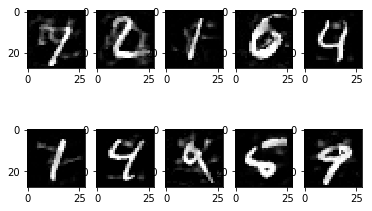

In [12]:
print 'Crafting adversarial examples against target model using vanilla model ...'
atk2 = Attack(x,y,[sub_model2],target_model,sess,100,lr=0.05)
st = time.time()
index = 0
legit_img = x_test[index:index+100]
legit_y = y_test[index:index+100]
other_params = {
    'total_run':5,
    'total_iters':500
}
adv_img2 = atk2.find_adv(legit_img,legit_y,other_params=other_params)
print 'Total attack time:',time.time() - st

total_l2=0
not_found=0
not_found_indices = []
dset = adv_img2
for i in range(len(dset)):
    if np.sum(dset[i])==np.prod(dset.shape[1:])*10:
        not_found+=1
        not_found_indices.append(i)
        continue
    total_l2+= np.linalg.norm(x_test[i] - dset[i])
print 'Success Rate: ', (len(dset) - not_found)/(len(dset)+0.)
print 'AVG L2 norm of crafted Adv. Examples:',total_l2/(100.-not_found)
print 'Sample Adv. Examples ...'
for i in range(10):
    plt.subplot(2,5,i+1)
    if dset[i].sum() == np.prod(dset.shape[1:])*10:
        plt.imshow(np.zeros((28,28)))
    plt.imshow(dset[i].reshape(28,28))